# Understanding High-Dimensional Biological Data
## A Comparison of PCA, t-SNE, and UMAP

### Project Motivation

Biological data is rarely small or simple. Gene expression profiles, single-cell RNA sequencing, proteomics, and other omics technologies routinely produce datasets with hundreds to tens of thousands of features for each biological sample. We humans, unfortunately evolved to see in three dimensions and reason comfortably in maybe a dozen more. anything beyond that is just hostile terrain.

This actually creates a core tension:
- Biological systems are high-dimensional by nature
- Human intuition is low by necessity

This is where dimensionality reduction comes in, to bridge this gap. Every dimensionality reduction method is a model which basically is "a set of assumptions about what structure matters and what structure can be discarded". Making this method an non-neutral tool.

In this project, we will compare three widely used techniques:
- **Principal Component Analysis (PCA)** - a linear, variance-focused model

- **t-SNE** - a nonlinear method optimized for local neighborhood structure

- **UMAP** - a graph-based approach balancing local and global structure

**Dataset**: To avoid accidental conclusions caused by messy real-world preprocessing, we'll work with synthetic gene-expresion-like data where the ground truth is known.


## Section 1 - Why High-Dimensional Biological Data Is Hard

### The Curse of Dimensionality

As dimensionality increases:

- Distances between points become less informative

- Nearest neighbors stop being meaningfully “near”

- Noise begins to dominate signal

In biological data, this effect is amplified by:

- Measurement noise

- Correlated features (genes rarely act alone)

- Overlapping biological states

Dimensionality reduction is therefore not optional. But the choice of method actually shapes the story our data tells.

## Section 2 - Generating Synthetic Gene Expression Data

### Why Synthetic Data?
Synthetic data offers some advantages:
1. We know how many biological groups exist
2. We can introduce noise intentionally
3. Failures become informative

### Design Goals for Our Dataset
We want data that:

- Has many genes

- Contains multiple cell types

- Exhibits overlap, not perfect separation

- Includes noise, as real experiments do

### Step 1: Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification # allows us to simulate complex, clustered data
from sklearn.preprocessing import StandardScaler

### Step 2: Generate High-Dimensional Gene Expression Data

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Define dataset characteristics
n_samples = 600          # number of biological samples
n_features = 1200        # number of genes (high-dimensional)
n_classes = 3            # number of biological conditions / cell types

# Generate synthetic gene expression-like data
X, y = make_classification(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=50,      # only a small subset of genes drive separation
    n_redundant=200,       # correlated genes
    n_classes=n_classes,
    n_clusters_per_class=1,
    flip_y=0.02,           # small label noise
    class_sep=1.5,         # moderate overlap between classes
    random_state=42
)

Now, we have our simulated biologically data:


- Most genes are not informative in that only a fraction drive phenotype

- Redundant genes represent co-regulated pathways

- Class overlap reflects biological similarity

- Label noise mimics experimental uncertainty

### Step 3: Scale the Data

In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

It is import we scale our data here because gene expression values can vary wildly in magnitude. So standardization ensures each gene contributes equally before we decide what structure matters.

### Step 4: Check Dataset Shape

In [4]:
print("Data shape:", X_scaled.shape)
print("Number of classes:", len(np.unique(y)))

Data shape: (600, 1200)
Number of classes: 3


## Section 3 - Geometry Before Reduction: Distance in High Dimensions

Most dimensionality reduction methods rely on distances between points. Now, if distances become unreliable, then any method built on them can be unreliable too.

In low dimesions, distances are informative. Some points are close, some, far. The difference matters. 

In high dimensions however, the closest and farthest points begin to look similar, distances concentrate around a narrow range and nearest neighbors lose their meaning. This phenomenom is known as distance concentration, and it is one of the core reasons high-dimensional data is hard to think about. 

### Step 1: Compute Pairwise Distances

We begin by measuring distances between samples in the original 1,200-dimensional space.

In [5]:
from sklearn.metrics import pairwise_distances

# Compute pairwise Euclidean distances
D = pairwise_distances(X_scaled, metric="euclidean")
D

array([[ 0.        , 47.61649843, 50.53894033, ..., 45.91995301,
        47.77879132, 48.57354594],
       [47.61649843,  0.        , 48.81215332, ..., 45.27038354,
        51.263937  , 47.87346682],
       [50.53894033, 48.81215332,  0.        , ..., 50.31247636,
        50.41269444, 50.57021924],
       ...,
       [45.91995301, 45.27038354, 50.31247636, ...,  0.        ,
        51.02358027, 49.88625399],
       [47.77879132, 51.263937  , 50.41269444, ..., 51.02358027,
         0.        , 54.16152546],
       [48.57354594, 47.87346682, 50.57021924, ..., 49.88625399,
        54.16152546,  0.        ]])

This produces a 600 × 600 distance matrix where each entry represents the distance between two samples

In [6]:
D.shape

(600, 600)

### Step 2: Inspect the Distribution of Distances

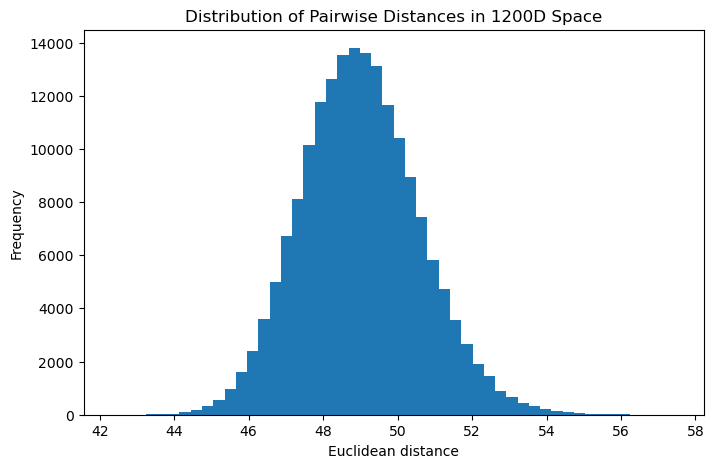

In [7]:
# Extract upper triangle distances (ignore zeros on diagonal)
distances = D[np.triu_indices_from(D, k=1)]

plt.figure(figsize=(8,5))
plt.hist(distances, bins=50)
plt.xlabel("Euclidean distance")
plt.ylabel("Frequency")
plt.title("Distribution of Pairwise Distances in 1200D Space")
plt.show()

Unlike low dimensional data, where one would expect a wide apread of distances and clear separation between near and far points, high dimensional data produces narrow distributions and most distances cluster around a similar value. 

### Step 3: Nearest vs Farthest Neighbor Ratio

In order to quantify distance concentration, let's compare: 

- Distance to the nearest neighbor and 
- Distance to the farthest neighbor

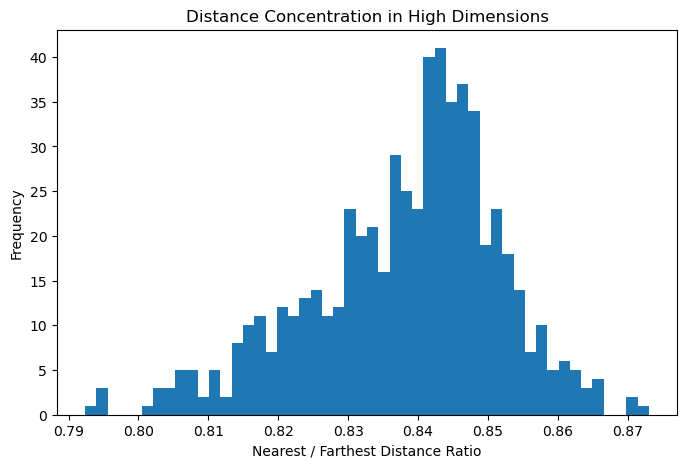

In [8]:
# Distance to nearest and farthest neighbor for each point
nearest_dist = np.min(D + np.eye(D.shape[0]) * np.max(D), axis=1)
farthest_dist = np.max(D, axis=1)

ratio = nearest_dist / farthest_dist

plt.figure(figsize=(8,5))
plt.hist(ratio, bins=50)
plt.xlabel("Nearest / Farthest Distance Ratio")
plt.ylabel("Frequency")
plt.title("Distance Concentration in High Dimensions")
plt.show()

In low dimensions, ratios are small (nearest << farthest). In high dimensions, ratios approach 1.


When this ratio becomes large, the concept of a “nearest neighbor” loses meaning.

## Section 4: PCA as a Linear Model of Reality

Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms high-dimensional data into lower dimensional data. It is a linear model that chooses a coordinate system where variance is maximized.

PCA assumes:

- The most important structure in the data is where variance is highest

- Linear combinations of features are sufficient to describe structure

- Orthogonal directions are meaningful

Basically, PCA rotates the data cloud to find the directions along which it spreads out the most.

### Step 1: Apply PCA to the High-Dimensional Data

We want to inspect the variance structure first

In [9]:
from sklearn.decomposition import PCA

# Fit PCA without limiting components (we want to inspect variance)
pca = PCA()
X_pca_full = pca.fit_transform(X_scaled)

Now, PCA has learned 1,200 orthogonal directions, ordered from highest to lowest variance

### Step 2: Explained Variance Analysis

The explained variance ratio tells us how much information each component captures.

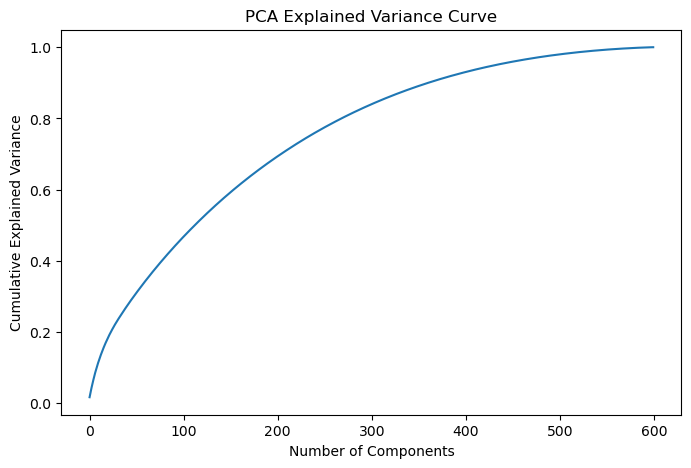

In [10]:
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(8,5))
plt.plot(np.cumsum(explained_variance))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance Curve")
plt.show()

This curve tells us that linear variance is not aligned with biological identity.

The absence of an elbow in the explained variance curve suggests that biologically relevant variation is distributed across many weak dimensions rather than concentrated in a few dominant linear axes.

### Step 3: PCA to 2D

Projecting data onto the two directions that explain the most variance.

In [11]:
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

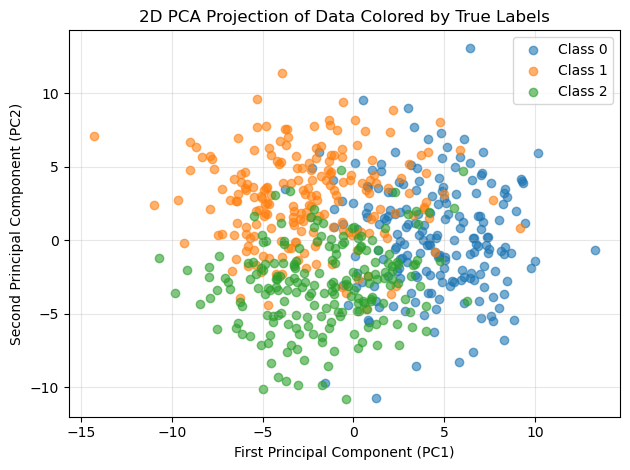

In [18]:
for label in np.unique(y):
    plt.scatter(
        X_pca_2d[y == label, 0],  # PC1 values for current class
        X_pca_2d[y == label, 1],  # PC2 values for current class
        alpha=0.6,               
        label=f'Class {label}'   
    )

plt.xlabel('First Principal Component (PC1)')
plt.ylabel('Second Principal Component (PC2)')
plt.title('2D PCA Projection of Data Colored by True Labels')
plt.legend() 
plt.grid(True, alpha=0.3)  
plt.tight_layout()  

# Display the plot
plt.show()

We see overlap, weak separation and broad clouds. This tells us that the axes of maximal variance are not aligned with this class identity.

Class separation is not the dominant source of variance.

In biology, variance is often driven by:

- Technical noise

- Batch effects

- Housekeeping genes

- Shared cellular processes

Our plot confirms that PCA successfully reduced our 1200-dimensional data to 2D while preserving meaningful class structure.

### Reconstruction error

This measures information loss when reducing from high dimensions to 2D.

Lower error means PCA retained more information from original data.

In [13]:
# Step 1: Reconstruct the original high-dimensional data from 2D PCA space
# inverse_transform() projects the 2D PCA data back to the original 1200D space

X_reconstructed = pca_2d.inverse_transform(X_pca_2d)

# Step 2: Calculate Mean Squared Error between original and reconstructed data
# Measures how much information was lost during dimensionality reduction

reconstruction_error = np.mean((X_scaled - X_reconstructed) ** 2)

print(f"Reconstruction Error (MSE): {reconstruction_error:.6f}")
print(f"This represents the average squared difference per feature after 2D compression")

Reconstruction Error (MSE): 0.969810
This represents the average squared difference per feature after 2D compression


Our reconstruction error of 0.97 indicates significant information loss when compressing from 1200D to 2D. This tells us that: 

Two principal components are good for seeing the data, not for fully recreating it.

### PCA loadings matrix creation

Loadings show the contribution (weight) of each original feature to each PC.

This helps interpret what each principal component represents.

In [14]:
loadings = pd.DataFrame(
    pca_2d.components_.T,  # Transpose: features × components matrix
    columns=["PC1", "PC2"]  # Name columns as PC1 and PC2
)

print(f"Loadings shape: {loadings.shape}")  # (1200, 2)
print(f"\nFirst 10 features' loadings:\n{loadings.head(10)}")

Loadings shape: (1200, 2)

First 10 features' loadings:
        PC1       PC2
0 -0.012335 -0.002397
1  0.003338  0.003555
2  0.009680 -0.002255
3  0.017722  0.014445
4 -0.013384  0.000611
5  0.010095  0.009418
6 -0.000117 -0.004301
7 -0.014904  0.007113
8 -0.047486 -0.060350
9  0.025339  0.054685


Each value answers how much a gene contributes to this direction of variance

## Section 5: t-SNE (t-Distributed Stochastic Neighbor Embedding)

In high-dimensional space, points that are close should have a high probability of being neighbors. t-SNE constructs a probability distribution of "who is close to whom". It then tries to recreate that same neighbor-probability structure in 2D (or 3D).

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Admin\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\Admin\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^

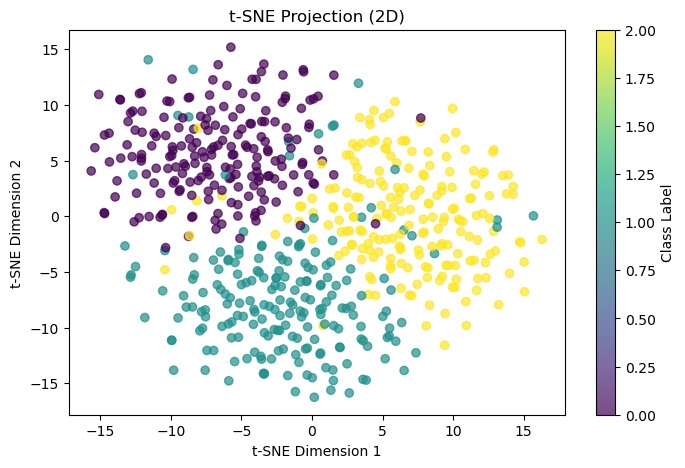

In [17]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,        # We want a 2D visualization
    perplexity=30,         # Controls neighborhood size (think: local vs global)
    learning_rate=200,     # Step size during optimization
    n_iter=1000,           # Enough iterations to stabilize
    random_state=42        # Reproducibility
)

X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8,5))
scatter = plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    c=y,
    cmap="viridis",
    alpha=0.7
)

plt.title("t-SNE Projection (2D)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.colorbar(scatter, label="Class Label")
plt.show()

The plot shows that the data comtains meaningful local structure: points that belong to the dame class tend to appear close to one another when the high-dimensional space is projected into two dimensions. 

The visualization suggests that class labels align reasonably well with the neighborhood relationships in the original data, indicating the presence of class-related signal.

## Conclusion

This project set out to explore how high-dimensional biological data behaves when we attempt to compress it into human-interpretable form. Through controlled synthetic data, distance analysis, PCA, and t-SNE, a consistent lesson emerged: dimensionality reduction does not reveal truth, it reveals perspectives shaped by assumptions.

PCA demonstrated the limits of linear thinking. The explained variance curve showed that information is distributed across many directions, and low-dimensional linear projections failed to cleanly separate classes. This was not a weakness of PCA, but an honest reflection of the data’s structure. PCA preserves variance and global geometry, and when clear separation does not appear, it signals that structure may be nonlinear or locally defined.

t-SNE, by contrast, produced visually compelling clusters by aggressively preserving local neighborhood relationships. The resulting plots highlighted meaningful local class coherence, but at the cost of distorting global distances, cluster sizes, and relative positioning. This made t-SNE a powerful exploratory tool, yet an unreliable source of quantitative or geometric conclusions if interpreted naively.

Taken together, these methods illustrate a central idea: dimensionality reduction is not a neutral compression of reality, but a modeling choice with trade-offs. PCA is conservative and interpretable, t-SNE is expressive and persuasive, and neither should be trusted in isolation. Visual clarity is not equivalent to statistical validity, and attractive embeddings demand intellectual restraint.

Ultimately, this notebook argues that responsible analysis of high-dimensional biological data requires skepticism toward visual intuition, awareness of algorithmic assumptions, and an understanding that models simplify reality rather than uncover it. Dimensionality reduction is best treated not as a final answer, but as a lens—useful, biased, and powerful only when its limitations are fully acknowledged.